# 0. Reading the Data
I will start with ride ID = 2975587283 which is the first ride of 2020 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/enriched/activities/2975587283.csv'
             }

df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
df['time'] = pd.to_datetime(df['time'])

In [3]:
df.head()

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time
0,2020-01-02 14:02:58+00:00,2.975587e+09,0.0,224.30,40.042824,-83.027358,1.0,1.0,1.0
1,2020-01-02 14:02:59+00:00,2.975587e+09,0.0,224.25,40.042851,-83.027424,2.0,1.0,2.0
2,2020-01-02 14:03:00+00:00,2.975587e+09,0.0,224.20,40.042877,-83.027490,3.0,1.0,3.0
3,2020-01-02 14:03:01+00:00,2.975587e+09,0.0,224.20,40.042896,-83.027535,4.0,1.0,4.0
4,2020-01-02 14:03:02+00:00,2.975587e+09,0.0,224.20,40.042914,-83.027581,5.0,1.0,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   time          1352 non-null   datetime64[ns, UTC]
 1   ride_id       1352 non-null   float64            
 2   segment_id    1352 non-null   float64            
 3   elevation     1352 non-null   float64            
 4   latitude      1352 non-null   float64            
 5   longitude     1352 non-null   float64            
 6   elapsed_time  1352 non-null   float64            
 7   delta_time    1352 non-null   float64            
 8   moving_time   1352 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(8)
memory usage: 95.2 KB


# 1. Calculating Distance Travelled

In [5]:
from haversine import haversine

def compute_distance(df, latitude='latitude', longitude='longitude', fill_first=np.nan):
    df = df.copy()
    # Copy the previous values of Lat/Long to the current row for vectorized computation
    df['lat_old'] = df[latitude].shift()
    df['long_old'] = df[longitude].shift()
    
    # Grab the relevant columns for distance calculation
    df_gps = df[['lat_old', 'long_old', latitude, longitude]]
    
    # Define an anonymous function to execute over each row to calculate the distance between rows
    haversine_distance = lambda x: haversine((x[0], x[1]), (x[2], x[3]), unit='mi')
    
    # Create the distance column, making sure to apply the function row-by-row
    df['delta_dist'] = df_gps.apply(haversine_distance, axis=1)
    df['delta_dist'] = df['delta_dist'].fillna(fill_first)
    
    # Remove the old latitude and longitude columns
    df.drop(['lat_old','long_old'], axis=1, inplace=True)
    return df

In [6]:
df = compute_distance(df)

In [7]:
# compute the cumulative distance elapsed
df['elapsed_distance'] = df['delta_dist'].cumsum()

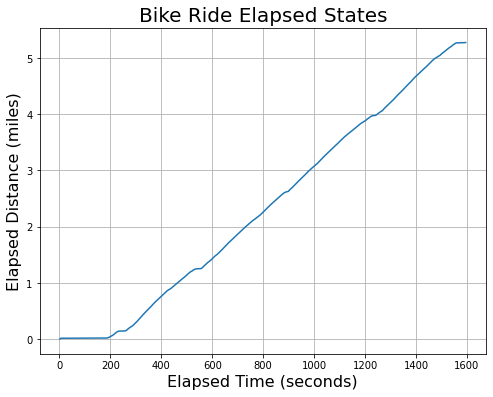

In [8]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(8,6))

_ = plt.plot(df['elapsed_time'], df['elapsed_distance'])
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elapsed Distance (miles)', fontsize=16)
_ = plt.title('Bike Ride Elapsed States', fontsize=20)
_ = plt.grid()

In [9]:
df.head(2)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance
0,2020-01-02 14:02:58+00:00,2.975587e+09,0.0,224.30,40.042824,-83.027358,1.0,1.0,1.0,NaN,NaN
1,2020-01-02 14:02:59+00:00,2.975587e+09,0.0,224.25,40.042851,-83.027424,2.0,1.0,2.0,0.003942,0.003942


In [10]:
df.tail(10)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance
1342,2020-01-02 14:28:55+00:00,2.975587e+09,3.0,223.8,40.042975,-83.027800,1558.0,1.0,1343.0,0.001125,5.267359
1343,2020-01-02 14:28:56+00:00,2.975587e+09,3.0,223.8,40.042963,-83.027794,1559.0,1.0,1344.0,0.000920,5.268279
1344,2020-01-02 14:28:57+00:00,2.975587e+09,3.0,223.8,40.042950,-83.027788,1560.0,1.0,1345.0,0.000920,5.269200
1345,2020-01-02 14:29:26+00:00,2.975587e+09,4.0,223.8,40.042963,-83.027746,1589.0,1.0,1346.0,0.002396,5.271596
1346,2020-01-02 14:29:27+00:00,2.975587e+09,4.0,223.8,40.042951,-83.027752,1590.0,1.0,1347.0,0.000873,5.272469
1347,2020-01-02 14:29:28+00:00,2.975587e+09,4.0,223.8,40.042940,-83.027759,1591.0,1.0,1348.0,0.000873,5.273342
1348,2020-01-02 14:29:29+00:00,2.975587e+09,4.0,223.8,40.042928,-83.027765,1592.0,1.0,1349.0,0.000873,5.274215
1349,2020-01-02 14:29:30+00:00,2.975587e+09,4.0,223.8,40.042937,-83.027759,1593.0,1.0,1350.0,0.000678,5.274892
1350,2020-01-02 14:29:31+00:00,2.975587e+09,4.0,223.8,40.042945,-83.027753,1594.0,1.0,1351.0,0.000678,5.275570
1351,2020-01-02 14:29:32+00:00,2.975587e+09,4.0,223.8,40.042954,-83.027747,1595.0,1.0,1352.0,0.000678,5.276248


# 2. Speed Calculation

In [11]:
miles_per_second_2_MPH = 3600.0 / 1.0 # conversion factor
df['speed'] = miles_per_second_2_MPH * df['delta_dist'] / df['delta_time']

### Visualizing Speed

In [12]:
def create_limited_palette(df, category_column, palette_name='deep'):
    # define the total length of the palette object needed to assign colors to @category_column
    num_total_colors = len(df[category_column].unique())
    
    # define the starting palette
    base_palette = np.array(sns.color_palette(palette_name))
    
    # calculate the repetition requirements for full and partial repeats
    num_full_repeats = int(num_total_colors / base_palette.shape[0])
    remainder_repeats = num_total_colors % base_palette.shape[0]
    #print(f'full = {num_full_repeats}, \t remainder = {remainder_repeats}')
    
    # create the new palette by repeating the base palette
    if num_full_repeats > 0:
        new_palette = base_palette
        for _ in range(0, num_full_repeats-1): # perform the full repeats
            new_palette = np.vstack((new_palette, base_palette))
        # perform the partial repeats for any remainder
        new_palette = np.vstack((new_palette, base_palette[0:remainder_repeats]))
    else:
        new_palette = base_palette[0:remainder_repeats]

    return new_palette

In [13]:
gpx_seg_palette = create_limited_palette(df, 'segment_id')

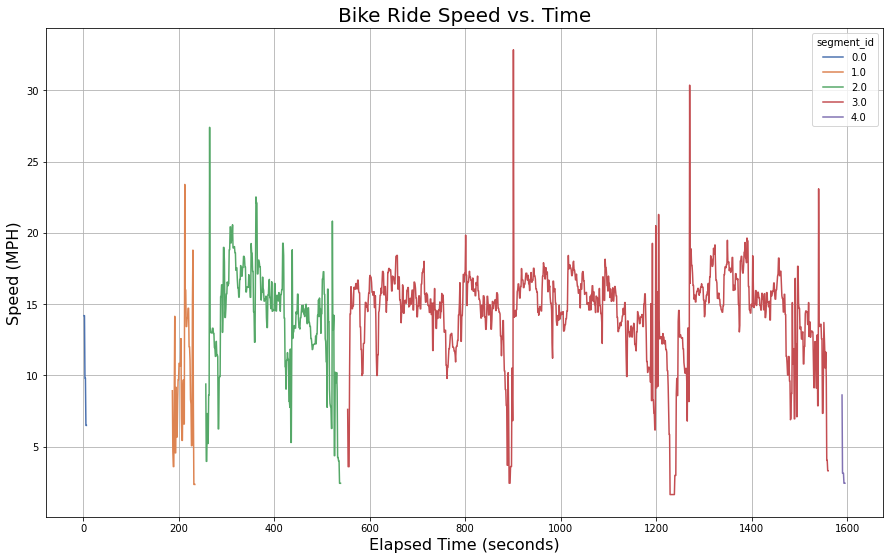

In [14]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()

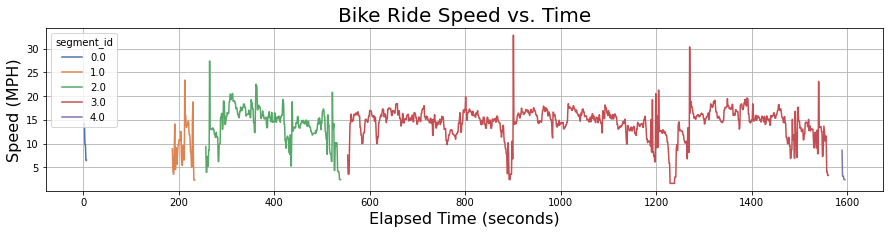

In [129]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,3))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()

### Is Cruising Flag -- Single Threshold

In [77]:
start_cruising_threshold = 8.0 # MPH
stop_cruising_threshold = 5.0 # MPH

In [135]:
df_temp = df.loc[df['segment_id']==2, ['time', 'elapsed_time','speed']].reset_index(drop=True)

In [136]:
df_temp.head()

,time,elapsed_time,speed
0,2020-01-02 14:07:14+00:00,257.0,9.394840
1,2020-01-02 14:07:15+00:00,258.0,3.974345
2,2020-01-02 14:07:16+00:00,259.0,3.974345
3,2020-01-02 14:07:17+00:00,260.0,7.329361
4,2020-01-02 14:07:18+00:00,261.0,5.229723


In [114]:
df_temp['is_cruising'] = (df_temp['speed']>start_cruising_threshold)

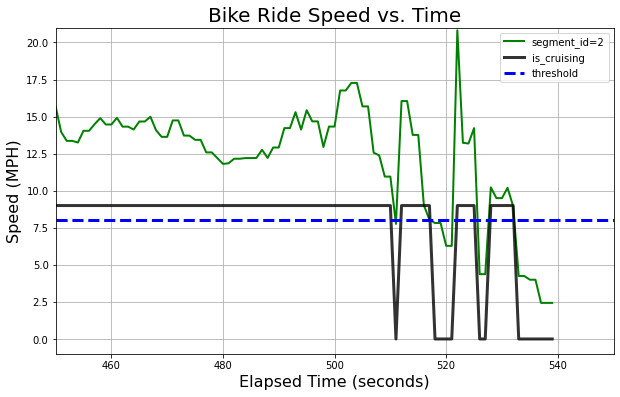

In [126]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(10,6))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df_temp, color='g', linewidth=2, label='segment_id=2')
_ = plt.plot(df_temp['elapsed_time'], (start_cruising_threshold+1) * df_temp['is_cruising'], 
             color='k', alpha=0.8, label='is_cruising', linewidth=3)
_ = plt.axhline(start_cruising_threshold, color='b', linestyle='--', linewidth=3, label='threshold')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()
#_ = plt.xlim([1150, 1300])
_ = plt.xlim([450, 550])
_ = plt.ylim([-1, 21])
_ = plt.legend()

### Is Cruising Flag -- Schmitt Trigger

In [137]:
df_temp['is_cruising'] = False

In [138]:
start_cruising_threshold = 8.0 # MPH
stop_cruising_threshold = 5.0 # MPH

for k in range(1, df_temp.shape[0]):
    previous_state = df_temp.loc[k-1,'is_cruising']
    current_speed = df_temp.loc[k,'speed']
    if (previous_state==False) & (current_speed >= start_cruising_threshold):
        df_temp.loc[k,'is_cruising'] = True # rising threshold surpassed
    elif (previous_state==True) & (current_speed < stop_cruising_threshold):
        df_temp.loc[k,'is_cruising'] = False # rising threshold surpassed
    else:
        # if there is no change, propogate the previous state
        df_temp.loc[k,'is_cruising'] = df_temp.loc[k-1,'is_cruising']

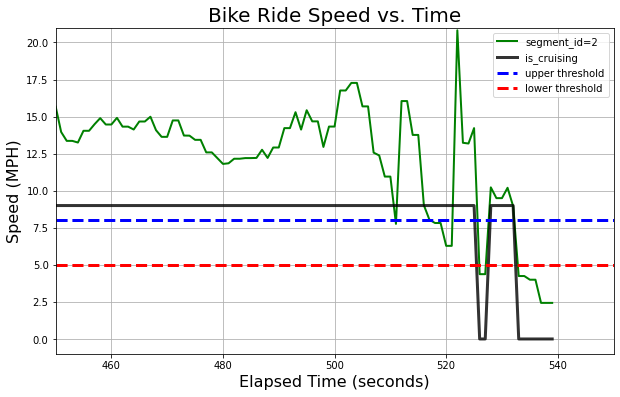

In [140]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(10,6))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df_temp, color='g', linewidth=2, label='segment_id=2')
_ = plt.plot(df_temp['elapsed_time'], (start_cruising_threshold+1) * df_temp['is_cruising'], 
             color='k', alpha=0.8, label='is_cruising', linewidth=3)
_ = plt.axhline(start_cruising_threshold, color='b', linestyle='--', linewidth=3, label='upper threshold')
_ = plt.axhline(stop_cruising_threshold, color='r', linestyle='--', linewidth=3, label='lower threshold')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()
#_ = plt.xlim([1150, 1300])
_ = plt.xlim([450, 550])
_ = plt.ylim([-1, 21])
_ = plt.legend()

In [141]:
def create_is_cruising(df, upper_threshold=8, lower_threshold=5):
    df = df.copy()
    
    df['is_cruising'] = False
    
    for k in range(1, df.shape[0]):
        previous_state = df.loc[k-1,'is_cruising']
        current_speed = df.loc[k,'speed']
        if (previous_state==False) & (current_speed >= start_cruising_threshold):
            df.loc[k,'is_cruising'] = True # rising threshold surpassed
        elif (previous_state==True) & (current_speed < stop_cruising_threshold):
            df.loc[k,'is_cruising'] = False # falling threshold exceeded
        else:
            # if there is no change, propogate the previous state
            df.loc[k,'is_cruising'] = df.loc[k-1,'is_cruising']
    
    return df

In [142]:
df = create_is_cruising(df)

In [153]:
df.head(10)

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance,speed,grade,elapsed_ascent,elapsed_descent,elapsed_elevation,is_cruising
0,2020-01-02 14:02:58+00:00,2.975587e+09,0.0,735.92830,40.042824,-83.027358,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.00000,0.00000,False
1,2020-01-02 14:02:59+00:00,2.975587e+09,0.0,735.76425,40.042851,-83.027424,2.0,1.0,2.0,0.003942,0.003942,14.191596,-0.788159,0.0,0.16405,0.16405,True
2,2020-01-02 14:03:00+00:00,2.975587e+09,0.0,735.60020,40.042877,-83.027490,3.0,1.0,3.0,0.003942,0.007884,14.191591,-0.788159,0.0,0.32810,0.32810,True
3,2020-01-02 14:03:01+00:00,2.975587e+09,0.0,735.60020,40.042896,-83.027535,4.0,1.0,4.0,0.002725,0.010609,9.810421,0.000000,0.0,0.32810,0.32810,True
4,2020-01-02 14:03:02+00:00,2.975587e+09,0.0,735.60020,40.042914,-83.027581,5.0,1.0,5.0,0.002725,0.013334,9.810419,0.000000,0.0,0.32810,0.32810,True
5,2020-01-02 14:03:03+00:00,2.975587e+09,0.0,735.60020,40.042924,-83.027613,6.0,1.0,6.0,0.001804,0.015138,6.493610,0.000000,0.0,0.32810,0.32810,True
6,2020-01-02 14:03:04+00:00,2.975587e+09,0.0,735.60020,40.042934,-83.027644,7.0,1.0,7.0,0.001804,0.016942,6.493609,0.000000,0.0,0.32810,0.32810,True
7,2020-01-02 14:06:04+00:00,2.975587e+09,1.0,735.60020,40.042900,-83.027659,187.0,1.0,8.0,0.002480,0.019422,8.926375,0.000000,0.0,0.32810,0.32810,True
8,2020-01-02 14:06:05+00:00,2.975587e+09,1.0,735.60020,40.042889,-83.027639,188.0,1.0,9.0,0.001303,0.020724,4.689420,0.000000,0.0,0.32810,0.32810,False
9,2020-01-02 14:06:06+00:00,2.975587e+09,1.0,735.60020,40.042884,-83.027621,189.0,1.0,10.0,0.001002,0.021726,3.605751,0.000000,0.0,0.32810,0.32810,False


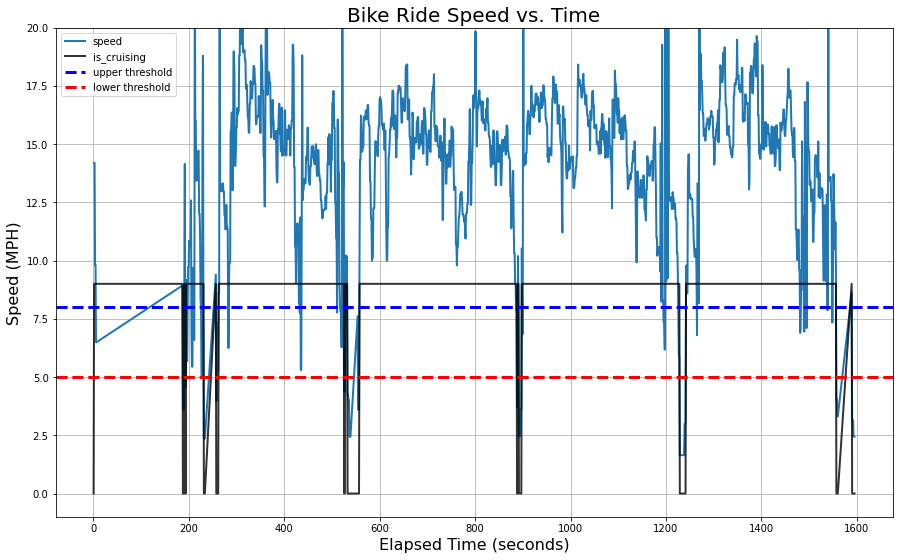

In [152]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df, linewidth=2, label='speed')
_ = plt.plot(df['elapsed_time'], (start_cruising_threshold+1) * df['is_cruising'], 
             color='k', alpha=0.8, label='is_cruising', linewidth=2)
_ = plt.axhline(start_cruising_threshold, color='b', linestyle='--', linewidth=3, label='upper threshold')
_ = plt.axhline(stop_cruising_threshold, color='r', linestyle='--', linewidth=3, label='lower threshold')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()
#_ = plt.xlim([1150, 1300])
#_ = plt.xlim([180, 250])
_ = plt.ylim([-1, 20])
_ = plt.legend()

In [157]:
# normal average speed
sec2hour = 1.0/3600
(df['elapsed_distance'] / (sec2hour*df['moving_time'])).tail()

1347    14.083109
1348    14.074999
1349    14.066380
1350    14.057774
1351    14.049181
dtype: float64

In [158]:
# normal average speed
np.mean(df['speed'])

14.059579841386444

In [159]:
# cruising average speed
np.mean(df.loc[df['is_cruising']==True, 'speed'])

14.534174881499617

# 3. Elevation & Grade

In [15]:
# We must double check the units of the elevation. 
# It does not look like the units displayed on Strava's website, but is most likely in meters
meters_to_feet = 3.281
df['elevation'] = df['elevation'] * meters_to_feet

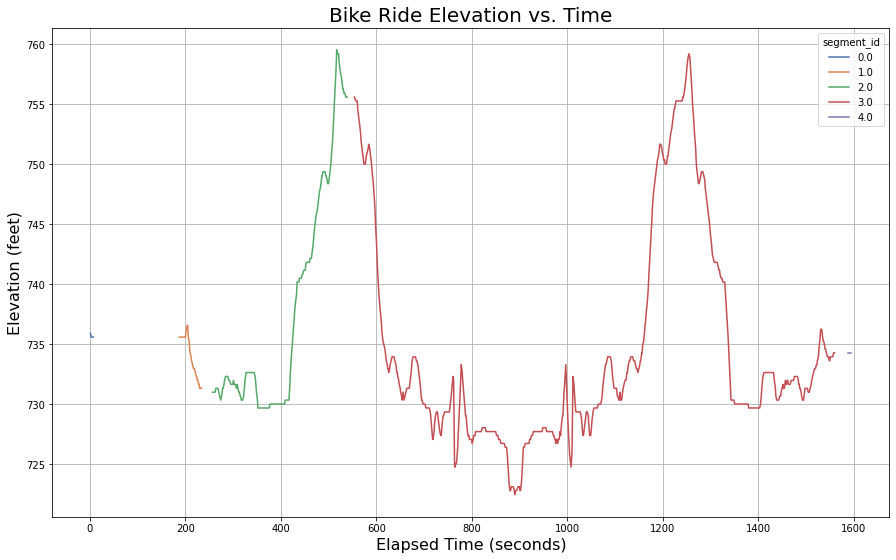

In [16]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='elevation', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elevation (feet)', fontsize=16)
_ = plt.title('Bike Ride Elevation vs. Time', fontsize=20)
_ = plt.grid()

### Terrain Gradient

In [17]:
def compute_grade(df, fill_first=0.0):
    df = df.copy()
    
    # create an elevation difference
    feet_to_miles = 1.0 / 5280.0
    df['delta_ele'] = df['elevation'].diff() * feet_to_miles
    df['delta_ele'] = df['delta_ele'].fillna(fill_first)
    
    # create the grade column as a percent
    df['grade'] = 100.0 * (df['delta_ele'] / df['delta_dist'])
    
    # drop the elevation difference
    df.drop(['delta_ele'], axis=1, inplace=True)
    
    return df

In [18]:
df = compute_grade(df)

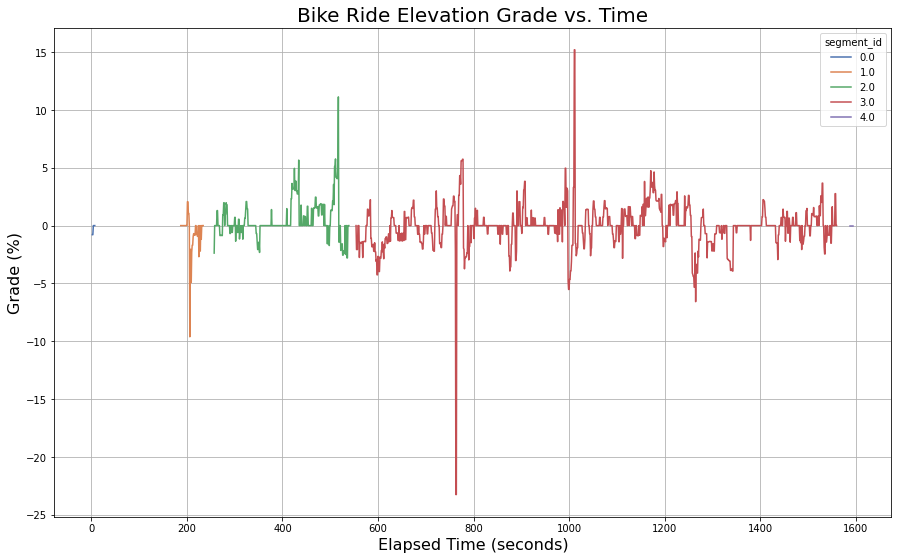

In [19]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='grade', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Grade (%)', fontsize=16)
_ = plt.title('Bike Ride Elevation Grade vs. Time', fontsize=20)
_ = plt.grid()

### Elapsed Elevation Ascent & Descent

In [62]:
def compute_cumulative_elevation_changes(df, fill_first=0.0):
    df = df.copy()
    
    # create an elevation difference
    df['delta_ele'] = df['elevation'].diff()
    df['delta_ele'] = df['delta_ele'].fillna(fill_first)
    
    # create delta ascent and delta descent columns
    df['delta_ascent'] = df.loc[df['delta_ele']>=0, 'delta_ele']
    df['delta_descent'] = df.loc[df['delta_ele']<=0, 'delta_ele']
    
    # create the cumulative versions
    df['elapsed_ascent'] = df['delta_ascent'].cumsum()
    df['elapsed_ascent'] = df['elapsed_ascent'].interpolate() # fill in any blanks
    df['elapsed_descent'] = df['delta_descent'].cumsum()
    df['elapsed_descent'] = np.abs(df['elapsed_descent'].interpolate()) # fill in any blanks
    
    # create the total elevation change column
    df['elapsed_elevation'] = df['elapsed_ascent'] + df['elapsed_descent']
        
    # drop the elevation differences
    df.drop(['delta_ele','delta_ascent','delta_descent'], axis=1, inplace=True)
    
    return df

In [64]:
df = compute_cumulative_elevation_changes(df)

In [66]:
df.tail()

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,elapsed_distance,speed,grade,elapsed_ascent,elapsed_descent,elapsed_elevation
1347,2020-01-02 14:29:28+00:00,2.975587e+09,4.0,734.2878,40.042940,-83.027759,1591.0,1.0,1348.0,0.000873,5.273342,3.142551,0.0,137.1458,138.7863,275.9321
1348,2020-01-02 14:29:29+00:00,2.975587e+09,4.0,734.2878,40.042928,-83.027765,1592.0,1.0,1349.0,0.000873,5.274215,3.142551,0.0,137.1458,138.7863,275.9321
1349,2020-01-02 14:29:30+00:00,2.975587e+09,4.0,734.2878,40.042937,-83.027759,1593.0,1.0,1350.0,0.000678,5.274892,2.439775,0.0,137.1458,138.7863,275.9321
1350,2020-01-02 14:29:31+00:00,2.975587e+09,4.0,734.2878,40.042945,-83.027753,1594.0,1.0,1351.0,0.000678,5.275570,2.439775,0.0,137.1458,138.7863,275.9321
1351,2020-01-02 14:29:32+00:00,2.975587e+09,4.0,734.2878,40.042954,-83.027747,1595.0,1.0,1352.0,0.000678,5.276248,2.439775,0.0,137.1458,138.7863,275.9321


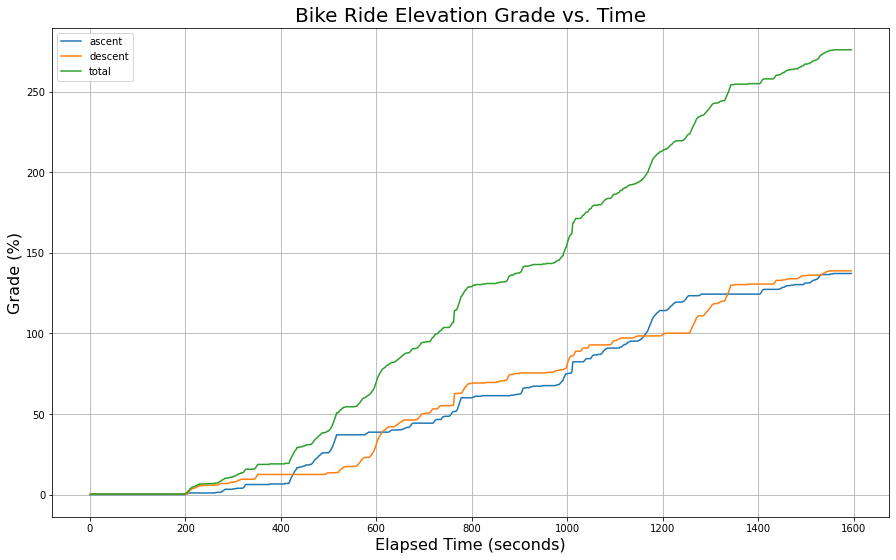

In [68]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='elapsed_ascent', data=df, label='ascent')
_ = sns.lineplot(x='elapsed_time', y='elapsed_descent', data=df, label='descent')
_ = sns.lineplot(x='elapsed_time', y='elapsed_elevation', data=df, label='total')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Elevation Change (ft)', fontsize=16)
_ = plt.title('Bike Ride Elevation Changes vs. Time', fontsize=20)
_ = plt.grid()

# 4. Training Window ID
We will split up the 2 years of data into 13 windows of 8 weeks each

In [161]:
import datetime as dt

In [192]:
start = dt.datetime(year=2020, month=1, day=2)
window_period = dt.timedelta(weeks=8)

In [193]:
start + window_period + 2*window_period

datetime.datetime(2020, 6, 18, 0, 0)

In [194]:
data = [{'training_window_id':i, 'start_date':start+window_period*i} for i in range(0,13)]

In [204]:
df_training_dates = pd.DataFrame(data=data)
df_training_dates['start_date'] = pd.to_datetime(df_training_dates['start_date'])
df_training_dates = df_training_dates.set_index('start_date').tz_localize('UTC').sort_index().reset_index()
df_training_dates

,start_date,training_window_id
0,2020-01-02 00:00:00+00:00,0
1,2020-02-27 00:00:00+00:00,1
2,2020-04-23 00:00:00+00:00,2
3,2020-06-18 00:00:00+00:00,3
4,2020-08-13 00:00:00+00:00,4
5,2020-10-08 00:00:00+00:00,5
6,2020-12-03 00:00:00+00:00,6
7,2021-01-28 00:00:00+00:00,7
8,2021-03-25 00:00:00+00:00,8
9,2021-05-20 00:00:00+00:00,9


In [205]:
df_training_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   start_date          13 non-null     datetime64[ns, UTC]
 1   training_window_id  13 non-null     int64              
dtypes: datetime64[ns, UTC](1), int64(1)
memory usage: 336.0 bytes


In [206]:
df[['time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   time    1352 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 10.7 KB


In [207]:
pd.merge_asof(df[['time']], df_training_dates, left_on='time', right_on='start_date')

,time,start_date,training_window_id
0,2020-01-02 14:02:58+00:00,2020-01-02 00:00:00+00:00,0
1,2020-01-02 14:02:59+00:00,2020-01-02 00:00:00+00:00,0
2,2020-01-02 14:03:00+00:00,2020-01-02 00:00:00+00:00,0
3,2020-01-02 14:03:01+00:00,2020-01-02 00:00:00+00:00,0
4,2020-01-02 14:03:02+00:00,2020-01-02 00:00:00+00:00,0
...,...,...,...
1347,2020-01-02 14:29:28+00:00,2020-01-02 00:00:00+00:00,0
1348,2020-01-02 14:29:29+00:00,2020-01-02 00:00:00+00:00,0
1349,2020-01-02 14:29:30+00:00,2020-01-02 00:00:00+00:00,0
1350,2020-01-02 14:29:31+00:00,2020-01-02 00:00:00+00:00,0


# 5. Heading
Based on [this image](https://exceljet.net/sites/default/files/images/functions/inline/exceljet_atan2_versus_atan.png), I want to use arctan2 to capture the full extent of the angles

For heading definition vs. bearing, see this [link](https://aviation.stackexchange.com/questions/8000/what-are-the-differences-between-bearing-vs-course-vs-direction-vs-heading-vs-tr)

In [210]:
rad2deg = 180.0 / np.pi
np.arctan2(1,1) * rad2deg

45.0

In [214]:
rad2deg = 180.0 / np.pi
# arctan2(y coords, x coords)
np.arctan2(-1,1) * rad2deg + 360

315.0

In [213]:
rad2deg = 180.0 / np.pi
# arctan2(y coords, x coords)
np.arctan2(-1,-1) * rad2deg + 360

225.0

In [217]:
np.sign(15)

1

In [221]:
def compute_heading(df, latitude='latitude', longitude='longitude'):
    df = df.copy()
    # Copy the previous values of Lat/Long to the current row for vectorized computation
    df['lat_old'] = df[latitude].shift()
    df['long_old'] = df[longitude].shift()
    
    # Grab the relevant columns for distance calculation
    df_gps = df[['lat_old', 'long_old', latitude, longitude]]
    
    # Define an anonymous function to execute over each row to calculate the angle with North as 0 degrees
    # NOTE: we use "delta_lat / delta_long" to ensure that North = 0 degrees
    rad2deg = 180.0 / np.pi
    haversine_distance = lambda x: rad2deg * np.arctan2((x[2]-x[0]), (x[3]-x[1])) # atan(delta_lat / delta_long)
    
    # Create the distance column, making sure to apply the function row-by-row
    df['heading'] = df_gps.apply(haversine_distance, axis=1)
    df['heading'] = df['heading'].apply(lambda x: x + 360.0*(1-np.sign(x))/2) # correct for negative angles
    
    # Remove the old latitude and longitude columns
    df.drop(['lat_old','long_old'], axis=1, inplace=True)
    return df

In [223]:
df = compute_heading(df)

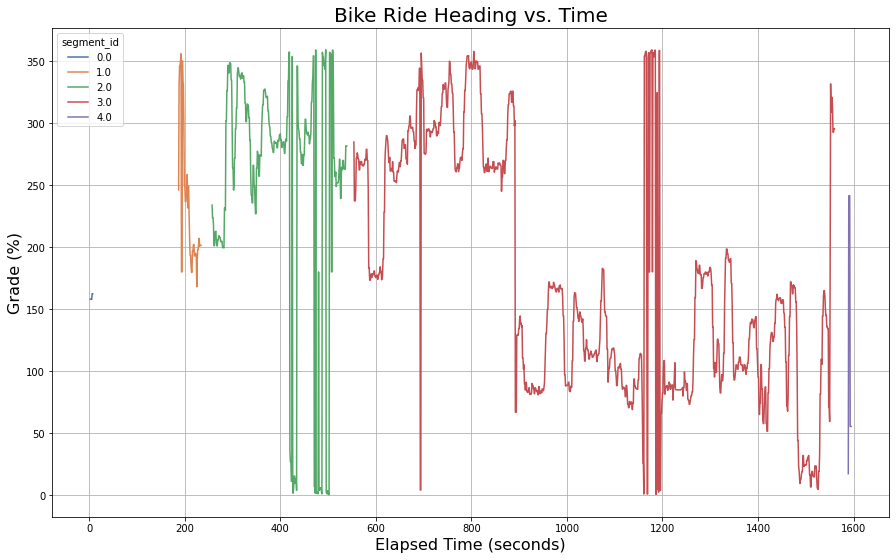

In [225]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,9))

_ = sns.lineplot(x='elapsed_time', y='heading', data=df, hue='segment_id', palette='deep')
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Grade (%)', fontsize=16)
_ = plt.title('Bike Ride Heading vs. Time', fontsize=20)
_ = plt.grid()